ADVANCED EDA: FINDING THE BREAKTHROUGH TO <5000

Dataset sizes:
  Receivals: 122383
  Materials: 1218
  Transportation: 122590
  Test predictions needed: 30450

[HYPOTHESIS 1] EXTENDED DATASETS - DO THEY ADD VALUE?

--- Materials Dataset ---
Columns: ['rm_id', 'product_id', 'product_version', 'raw_material_alloy', 'raw_material_format_type', 'stock_location']
Non-null rows: rm_id                       1217
product_id                  1217
product_version             1217
raw_material_alloy          1217
raw_material_format_type    1217
stock_location              1217
dtype: int64

Sample:
   rm_id  product_id  product_version raw_material_alloy  raw_material_format_type                       stock_location
0    NaN         NaN              NaN                NaN                       NaN                                  NaN
1  342.0  91900170.0              1.0       SB06 Traders                      24.0       DELETED_28.02:2011_SB06 anodiz
2  343.0  91900143.0              2.0      

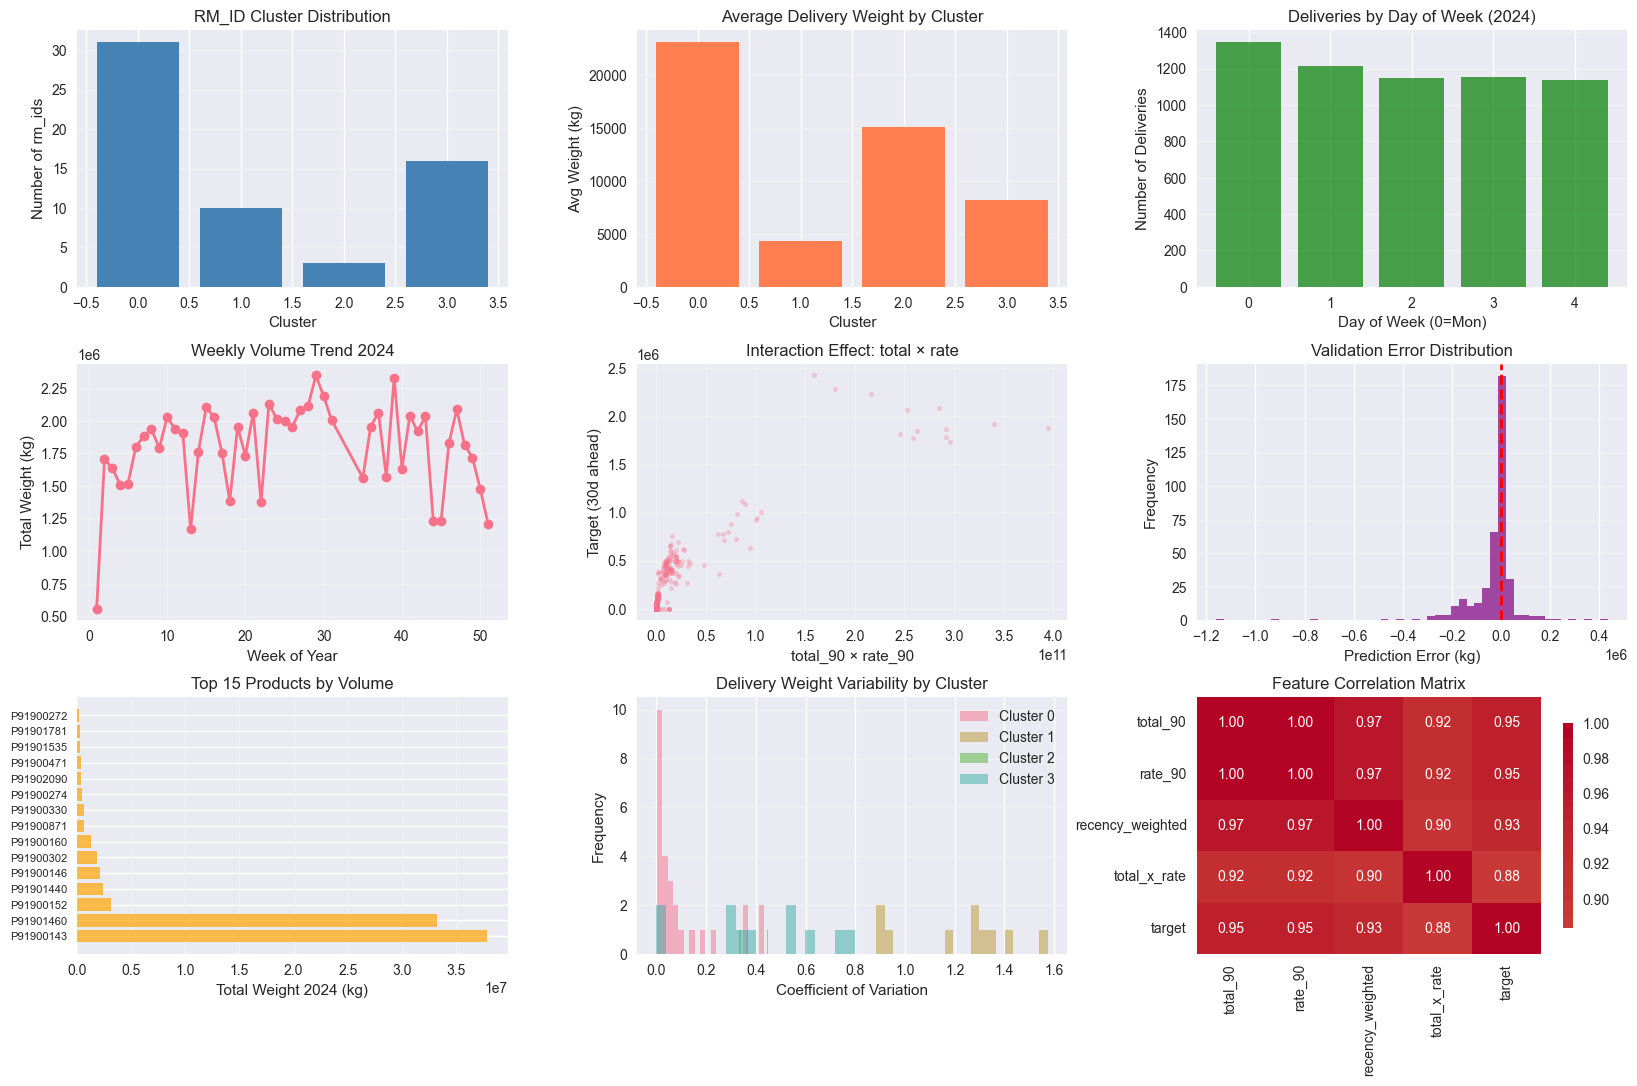

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats
from sklearn.cluster import KMeans

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load ALL data including extended datasets
receivals = pd.read_csv('./Project_materials/data/kernel/receivals.csv')
purchase_orders = pd.read_csv('./Project_materials/data/kernel/purchase_orders.csv')
materials = pd.read_csv('./Project_materials/data/extended/materials.csv')
transportation = pd.read_csv('./Project_materials/data/extended/transportation.csv')
prediction_mapping = pd.read_csv('./Project_materials/data/prediction_mapping.csv')

# Convert dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)

print("="*80)
print("ADVANCED EDA: FINDING THE BREAKTHROUGH TO <5000")
print("="*80)

receivals = receivals[receivals['net_weight'] > 0]
receivals = receivals[receivals['rm_id'].notna()]
receivals = receivals.sort_values('date_arrival')

print(f"\nDataset sizes:")
print(f"  Receivals: {len(receivals)}")
print(f"  Materials: {len(materials)}")
print(f"  Transportation: {len(transportation)}")
print(f"  Test predictions needed: {len(prediction_mapping)}")

# ============================================================================
# HYPOTHESIS 1: Extended datasets contain predictive signals
# ============================================================================
print("\n[HYPOTHESIS 1] EXTENDED DATASETS - DO THEY ADD VALUE?")
print("="*80)

print("\n--- Materials Dataset ---")
print(f"Columns: {materials.columns.tolist()}")
print(f"Non-null rows: {materials.notna().sum()}")
print(f"\nSample:")
print(materials.head(10).to_string())

# Check materials coverage
materials_clean = materials.dropna(subset=['rm_id'])
test_rm_ids = prediction_mapping['rm_id'].unique()
materials_coverage = materials_clean[materials_clean['rm_id'].isin(test_rm_ids)]

print(f"\nMaterials coverage:")
print(f"  Total rm_ids in materials: {materials_clean['rm_id'].nunique()}")
print(f"  Test rm_ids with materials info: {materials_coverage['rm_id'].nunique()}/{len(test_rm_ids)}")
print(f"  Coverage: {materials_coverage['rm_id'].nunique()/len(test_rm_ids)*100:.1f}%")

if len(materials_coverage) > 0:
    print(f"\n  Material types (raw_material_alloy):")
    print(materials_coverage['raw_material_alloy'].value_counts().head(10).to_string())
    
    print(f"\n  Format types:")
    print(materials_coverage['raw_material_format_type'].value_counts().head(10).to_string())

print("\n--- Transportation Dataset ---")
print(f"Columns: {transportation.columns.tolist()}")
print(f"Rows: {len(transportation)}")
print(f"\nSample:")
print(transportation.head(10).to_string())

# Check if transportation adds info not in receivals
print(f"\nTransportation coverage:")
transport_rm_ids = transportation['rm_id'].unique()
print(f"  Unique rm_ids in transportation: {len(transport_rm_ids)}")
print(f"  Test rm_ids in transportation: {len([r for r in test_rm_ids if r in transport_rm_ids])}/{len(test_rm_ids)}")

# Check for useful columns
print(f"\n  Transporters: {transportation['transporter_name'].nunique()} unique")
print(f"  Vehicles: {transportation['vehicle_no'].nunique()} unique")

# ============================================================================
# HYPOTHESIS 2: rm_ids have distinct behavioral clusters
# ============================================================================
print("\n[HYPOTHESIS 2] RM_ID CLUSTERING - DIFFERENT BEHAVIORS?")
print("="*80)

# Build rm_id profiles for 2024
active_rm_ids = receivals[receivals['date_arrival'] >= '2024-01-01']['rm_id'].unique()
print(f"Active rm_ids in 2024: {len(active_rm_ids)}")

rm_profiles = []
for rm_id in active_rm_ids:
    hist = receivals[receivals['rm_id'] == rm_id]
    hist_2024 = hist[hist['date_arrival'] >= '2024-01-01']
    
    if len(hist_2024) == 0:
        continue
    
    profile = {
        'rm_id': rm_id,
        'total_deliveries': len(hist_2024),
        'avg_weight': hist_2024['net_weight'].mean(),
        'std_weight': hist_2024['net_weight'].std(),
        'cv_weight': hist_2024['net_weight'].std() / hist_2024['net_weight'].mean() if hist_2024['net_weight'].mean() > 0 else 0,
        'total_volume': hist_2024['net_weight'].sum(),
        'days_span': (hist_2024['date_arrival'].max() - hist_2024['date_arrival'].min()).days,
        'delivery_frequency': len(hist_2024) / ((hist_2024['date_arrival'].max() - hist_2024['date_arrival'].min()).days + 1) if len(hist_2024) > 1 else 0,
        'unique_suppliers': hist_2024['supplier_id'].nunique(),
        'trend': 'increasing' if len(hist_2024) > 1 and hist_2024.iloc[-1]['net_weight'] > hist_2024.iloc[0]['net_weight'] else 'decreasing'
    }
    rm_profiles.append(profile)

profile_df = pd.DataFrame(rm_profiles)

print(f"\nRM Profile Statistics:")
print(profile_df.describe().to_string())

# Cluster rm_ids
features_for_clustering = ['total_deliveries', 'avg_weight', 'cv_weight', 'delivery_frequency']
X_cluster = profile_df[features_for_clustering].fillna(0)

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
profile_df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"\n--- RM_ID Clusters (k={n_clusters}) ---")
for i in range(n_clusters):
    cluster_data = profile_df[profile_df['cluster'] == i]
    print(f"\nCluster {i}: {len(cluster_data)} rm_ids")
    print(f"  Avg deliveries: {cluster_data['total_deliveries'].mean():.1f}")
    print(f"  Avg weight: {cluster_data['avg_weight'].mean():,.0f} kg")
    print(f"  Avg CV: {cluster_data['cv_weight'].mean():.2f}")
    print(f"  Avg frequency: {cluster_data['delivery_frequency'].mean():.3f} deliveries/day")

# Check which clusters are in test set
test_rm_clusters = profile_df[profile_df['rm_id'].isin(test_rm_ids)]
print(f"\nTest set cluster distribution:")
print(test_rm_clusters['cluster'].value_counts().to_string())

# ============================================================================
# HYPOTHESIS 3: Feature interactions matter (non-linearity)
# ============================================================================
print("\n[HYPOTHESIS 3] FEATURE INTERACTIONS - NON-LINEAR EFFECTS?")
print("="*80)

# Build dataset with potential interactions
test_dates = pd.date_range('2024-09-01', '2024-11-30', freq='W')
interaction_data = []

for test_date in test_dates:
    for rm_id in active_rm_ids[:40]:  # Sample for speed
        hist = receivals[(receivals['rm_id'] == rm_id) & (receivals['date_arrival'] < test_date)]
        
        if len(hist) < 3:
            continue
        
        cutoff_90 = test_date - timedelta(days=90)
        recent_90 = hist[hist['date_arrival'] >= cutoff_90]
        
        if len(recent_90) == 0:
            continue
        
        total_90 = recent_90['net_weight'].sum()
        count_90 = len(recent_90)
        rate_90 = total_90 / 90
        
        # Recency weighted
        days_ago = (test_date - recent_90['date_arrival']).dt.days
        weights = 1.0 / (days_ago + 1)
        recency_weighted = (recent_90['net_weight'] * weights).sum()
        
        # Get target
        forecast_end = test_date + timedelta(days=30)
        actual = receivals[(receivals['rm_id'] == rm_id) & 
                          (receivals['date_arrival'] >= test_date) & 
                          (receivals['date_arrival'] <= forecast_end)]
        target = actual['net_weight'].sum()
        
        # Interaction features
        interaction_data.append({
            'total_90': total_90,
            'rate_90': rate_90,
            'recency_weighted': recency_weighted,
            'count_90': count_90,
            # NEW: Interactions
            'total_x_rate': total_90 * rate_90,
            'recency_x_count': recency_weighted * count_90,
            'total_squared': total_90 ** 2,
            'rate_squared': rate_90 ** 2,
            'total_div_count': total_90 / count_90 if count_90 > 0 else 0,
            'target': target
        })

interact_df = pd.DataFrame(interaction_data)

print(f"\nGenerated {len(interact_df)} samples for interaction analysis")

# Correlation with target
if len(interact_df) > 0:
    print("\n--- Feature Correlations (including interactions) ---")
    corr_with_target = interact_df.corr()['target'].drop('target').sort_values(ascending=False)
    for feat, corr in corr_with_target.items():
        stars = "***" if abs(corr) > 0.7 else "**" if abs(corr) > 0.5 else "*" if abs(corr) > 0.3 else ""
        print(f"{feat:25s}: {corr:+.4f} {stars}")

# ============================================================================
# HYPOTHESIS 4: Temporal patterns within 2024 we're missing
# ============================================================================
print("\n[HYPOTHESIS 4] TEMPORAL PATTERNS - WEEK/DAY EFFECTS?")
print("="*80)

# Add temporal features
receivals['day_of_week'] = receivals['date_arrival'].dt.dayofweek
receivals['week_of_year'] = receivals['date_arrival'].dt.isocalendar().week
receivals['month'] = receivals['date_arrival'].dt.month

recent_receivals = receivals[receivals['date_arrival'] >= '2024-01-01']

print("\n--- Day of Week Analysis ---")
dow_stats = recent_receivals.groupby('day_of_week').agg({
    'net_weight': ['count', 'mean', 'sum']
}).reset_index()
dow_stats.columns = ['day_of_week', 'count', 'avg_weight', 'total_weight']
# Map day numbers to names
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
dow_stats['day_name'] = dow_stats['day_of_week'].map(day_map)
print(dow_stats.to_string(index=False))

print("\n--- Week of Year Pattern ---")
week_stats = recent_receivals.groupby('week_of_year')['net_weight'].agg(['count', 'sum']).reset_index()
week_stats.columns = ['week', 'count', 'total']

# Check for trend within 2024
if len(week_stats) > 10:
    early_weeks = week_stats[week_stats['week'] <= 20]['total'].mean()
    late_weeks = week_stats[week_stats['week'] > 35]['total'].mean()
    print(f"\nEarly 2024 (weeks 1-20): {early_weeks:,.0f} kg/week")
    print(f"Late 2024 (weeks 35+): {late_weeks:,.0f} kg/week")
    print(f"Change: {((late_weeks - early_weeks) / early_weeks * 100):+.1f}%")

# ============================================================================
# HYPOTHESIS 5: Are we under-predicting or over-predicting specific horizons?
# ============================================================================
print("\n[HYPOTHESIS 5] HORIZON-SPECIFIC ERRORS - WHERE ARE WE WRONG?")
print("="*80)

# Simulate current model's behavior on validation
from datetime import timedelta

val_predictions = []
val_dates = pd.date_range('2024-09-01', '2024-11-30', freq='W')

for val_date in val_dates:
    for rm_id in active_rm_ids[:30]:  # Sample
        hist = receivals[(receivals['rm_id'] == rm_id) & (receivals['date_arrival'] < val_date)]
        
        if len(hist) == 0:
            continue
        
        cutoff_90 = val_date - timedelta(days=90)
        recent_90 = hist[hist['date_arrival'] >= cutoff_90]
        
        if len(recent_90) == 0:
            simple_pred = 0
        else:
            # Simple proxy: average rate
            total_90 = recent_90['net_weight'].sum()
            rate_90 = total_90 / 90
            simple_pred = rate_90 * 30  # 30-day forecast
        
        # Actual
        forecast_end = val_date + timedelta(days=30)
        actual = receivals[(receivals['rm_id'] == rm_id) & 
                          (receivals['date_arrival'] >= val_date) & 
                          (receivals['date_arrival'] <= forecast_end)]
        actual_val = actual['net_weight'].sum()
        
        val_predictions.append({
            'predicted': simple_pred,
            'actual': actual_val,
            'error': simple_pred - actual_val,
            'pct_error': ((simple_pred - actual_val) / actual_val * 100) if actual_val > 0 else 0
        })

val_df = pd.DataFrame(val_predictions)

if len(val_df) > 0:
    print(f"\nValidation error analysis (n={len(val_df)}):")
    print(f"  Mean prediction: {val_df['predicted'].mean():,.0f} kg")
    print(f"  Mean actual: {val_df['actual'].mean():,.0f} kg")
    print(f"  Mean error: {val_df['error'].mean():,.0f} kg")
    print(f"  Over-predictions: {(val_df['error'] > 0).sum()} ({(val_df['error'] > 0).sum()/len(val_df)*100:.1f}%)")
    print(f"  Under-predictions: {(val_df['error'] < 0).sum()} ({(val_df['error'] < 0).sum()/len(val_df)*100:.1f}%)")

# ============================================================================
# HYPOTHESIS 6: Product_id matters (different products = different patterns)
# ============================================================================
print("\n[HYPOTHESIS 6] PRODUCT_ID PATTERNS - DO PRODUCTS DIFFER?")
print("="*80)

product_stats = receivals[receivals['date_arrival'] >= '2024-01-01'].groupby('product_id').agg({
    'net_weight': ['count', 'mean', 'sum'],
    'rm_id': 'nunique'
}).reset_index()
product_stats.columns = ['product_id', 'deliveries', 'avg_weight', 'total_weight', 'unique_rm_ids']

print(f"\nTop 10 products by volume (2024):")
print(product_stats.nlargest(10, 'total_weight').to_string(index=False))

# Check if test rm_ids use specific products
test_rm_receivals = receivals[receivals['rm_id'].isin(test_rm_ids)]
test_products = test_rm_receivals['product_id'].unique()

print(f"\nProduct usage:")
print(f"  Total products: {receivals['product_id'].nunique()}")
print(f"  Products used by test rm_ids: {len(test_products)}")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n[VISUALIZATION] CREATING DIAGNOSTIC PLOTS")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Cluster profiles
ax1 = fig.add_subplot(gs[0, 0])
cluster_sizes = profile_df['cluster'].value_counts().sort_index()
ax1.bar(cluster_sizes.index, cluster_sizes.values, color='steelblue')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of rm_ids')
ax1.set_title('RM_ID Cluster Distribution')
ax1.grid(alpha=0.3, axis='y')

# Plot 2: Cluster characteristics
ax2 = fig.add_subplot(gs[0, 1])
cluster_avgs = profile_df.groupby('cluster')['avg_weight'].mean()
ax2.bar(cluster_avgs.index, cluster_avgs.values, color='coral')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Avg Weight (kg)')
ax2.set_title('Average Delivery Weight by Cluster')
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Day of week pattern
ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(dow_stats['day_of_week'], dow_stats['count'], color='green', alpha=0.7)
ax3.set_xlabel('Day of Week (0=Mon)')
ax3.set_ylabel('Number of Deliveries')
ax3.set_title('Deliveries by Day of Week (2024)')
ax3.grid(alpha=0.3, axis='y')

# Plot 4: Week trend
ax4 = fig.add_subplot(gs[1, 0])
if len(week_stats) > 0:
    ax4.plot(week_stats['week'], week_stats['total'], marker='o', linewidth=2)
    ax4.set_xlabel('Week of Year')
    ax4.set_ylabel('Total Weight (kg)')
    ax4.set_title('Weekly Volume Trend 2024')
    ax4.grid(alpha=0.3)

# Plot 5: Interaction scatter (if data exists)
ax5 = fig.add_subplot(gs[1, 1])
if len(interact_df) > 0 and 'total_x_rate' in interact_df.columns:
    sample = interact_df.sample(min(500, len(interact_df)))
    ax5.scatter(sample['total_x_rate'], sample['target'], alpha=0.3, s=10)
    ax5.set_xlabel('total_90 × rate_90')
    ax5.set_ylabel('Target (30d ahead)')
    ax5.set_title('Interaction Effect: total × rate')
    ax5.grid(alpha=0.3)

# Plot 6: Error distribution
ax6 = fig.add_subplot(gs[1, 2])
if len(val_df) > 0:
    ax6.hist(val_df['error'], bins=50, color='purple', alpha=0.7)
    ax6.axvline(0, color='red', linestyle='--', linewidth=2)
    ax6.set_xlabel('Prediction Error (kg)')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Validation Error Distribution')
    ax6.grid(alpha=0.3, axis='y')

# Plot 7: Product distribution
ax7 = fig.add_subplot(gs[2, 0])
top_products = product_stats.nlargest(15, 'total_weight')
ax7.barh(range(len(top_products)), top_products['total_weight'], color='orange', alpha=0.7)
ax7.set_yticks(range(len(top_products)))
ax7.set_yticklabels([f"P{int(p)}" for p in top_products['product_id']], fontsize=8)
ax7.set_xlabel('Total Weight 2024 (kg)')
ax7.set_title('Top 15 Products by Volume')
ax7.grid(alpha=0.3, axis='x')

# Plot 8: CV distribution by cluster
ax8 = fig.add_subplot(gs[2, 1])
for i in range(n_clusters):
    cluster_cvs = profile_df[profile_df['cluster'] == i]['cv_weight']
    ax8.hist(cluster_cvs, bins=20, alpha=0.5, label=f'Cluster {i}')
ax8.set_xlabel('Coefficient of Variation')
ax8.set_ylabel('Frequency')
ax8.set_title('Delivery Weight Variability by Cluster')
ax8.legend()
ax8.grid(alpha=0.3, axis='y')

# Plot 9: Correlation heatmap
ax9 = fig.add_subplot(gs[2, 2])
if len(interact_df) > 0:
    corr_matrix = interact_df[['total_90', 'rate_90', 'recency_weighted', 'total_x_rate', 'target']].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax9, cbar_kws={'shrink': 0.8})
    ax9.set_title('Feature Correlation Matrix')

plt.savefig('advanced_eda_breakthrough.png', dpi=300, bbox_inches='tight')
print("Saved to 'advanced_eda_breakthrough.png'")

# ============================================================================
# KEY FINDINGS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*80)

findings = []

# Finding 1: Extended datasets
if materials_coverage['rm_id'].nunique() / len(test_rm_ids) > 0.5:
    findings.append(f"✅ Materials data covers {materials_coverage['rm_id'].nunique()}/{len(test_rm_ids)} test rm_ids - could add material_type features")
else:
    findings.append(f"❌ Materials data only covers {materials_coverage['rm_id'].nunique()}/{len(test_rm_ids)} test rm_ids - not useful")

# Finding 2: Clusters
findings.append(f"✅ Identified {n_clusters} distinct rm_id clusters with different behaviors")
findings.append(f"   → Consider cluster-specific models or cluster as a feature")

# Finding 3: Interactions
if len(interact_df) > 0:
    best_interaction = corr_with_target.iloc[0]
    if abs(best_interaction) > 0.75:
        findings.append(f"✅ Strong interaction feature found: {corr_with_target.index[0]} (r={best_interaction:.3f})")
    else:
        findings.append(f"⚠️ Interaction features weak - best: {corr_with_target.index[0]} (r={best_interaction:.3f})")

# Finding 4: Temporal
if abs((late_weeks - early_weeks) / early_weeks) > 0.15:
    findings.append(f"✅ Strong temporal trend detected: {((late_weeks - early_weeks) / early_weeks * 100):+.1f}% change")
else:
    findings.append(f"⚠️ Temporal trend within 2024 is moderate")

# Finding 5: Errors
if len(val_df) > 0:
    over_pct = (val_df['error'] > 0).sum() / len(val_df) * 100
    if over_pct > 55:
        findings.append(f"⚠️ Over-predicting {over_pct:.0f}% of the time - need more conservatism")
    elif over_pct < 45:
        findings.append(f"⚠️ Under-predicting {100-over_pct:.0f}% of the time - predictions too low")
    else:
        findings.append(f"✅ Prediction balance reasonable ({over_pct:.0f}% over-predictions)")

print("\n" + "-"*80)
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

print("\n" + "="*80)
print("Next steps: Review findings and decide which insights to implement!")
print("="*80)

cluster_map = profile_df.set_index('rm_id')['cluster'].to_dict()
print(cluster_map)